# Libraries

In [161]:
# set homw directory
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring')

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [163]:
from utilities.utils import load_json, load_pickle, get_models
from utilities.pathManager import fetchPaths

In [164]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# Setup Variables and home directory

MNIST, FashionMNIST, GTSRB, Cifar10

In [165]:
# DATASET = 'MNIST'
# DATASET = 'FashionMNIST'
DATASET = 'GTSRB'

# print available models
model_names = get_models(base, DATASET)
model_names

['AdamW-32-30', 'AdamW-32-50', 'AdamW-32-80', 'AdamW-32-150']

In [166]:
fixed_model = {
    'MNIST': 60,
    'FashionMNIST': 30,
    'GTSRB': 50,
}

In [167]:
POSTFIX = f"{model_names[0].rsplit('-',1)[0]}-{fixed_model[DATASET]}"
FILENAME_POSTFIX = f'{DATASET}_{POSTFIX}'

# Paths

In [168]:
paths = fetchPaths(base, DATASET, POSTFIX, False)

path_data = paths['data']
path_lhl = paths['lhl']
path_lhl_raw = paths['lhl_raw']
path_lhl_pca = paths['lhl_pca']

# Import Data

In [169]:
# raw Data
df_train = pd.read_csv(path_lhl_raw / f"{FILENAME_POSTFIX}_raw_train.csv")
df_test = pd.read_csv(path_lhl_raw / f"{FILENAME_POSTFIX}_raw_test.csv")
df_eval = pd.read_csv(path_lhl_raw / f"{FILENAME_POSTFIX}_raw_evaluation.csv")

# pca data
df_train_pca = pd.read_csv(path_lhl_pca / f"{FILENAME_POSTFIX}_pca_train.csv")
df_test_pca = pd.read_csv(path_lhl_pca / f"{FILENAME_POSTFIX}_pca_test.csv")
df_eval_pca = pd.read_csv(path_lhl_pca / f"{FILENAME_POSTFIX}_pca_evaluation.csv")

In [170]:
print(f"Train accuracy: {round(df_train['true'].sum() / df_train.shape[0], 4)*100}")
print(f"Test accuracy: {round(df_test['true'].sum() / df_test.shape[0], 4)*100}")
print(f"Evaluation accuracy: {round(df_eval['true'].sum() / df_eval.shape[0], 4)*100}")

Train accuracy: 96.33
Test accuracy: 96.33
Evaluation accuracy: 100.0


In [171]:
pca = load_pickle(path_lhl / 'pca.pkl')
scaler = load_pickle(path_lhl / 'scaler.pkl')

### Visualizations

In [172]:
from utilities.scaleFunctions import fitStandardScalerSingle
from utilities.pcaFunctions import fitPCASingle, numComponents

In [173]:
y = df_train['y']
true = df_train['true']
x = df_train.drop(['y', 'true'], axis=1).to_numpy()

y_pca = df_train_pca['y']
true_pca = df_train_pca['true']
x_pca = df_train_pca.drop(['y', 'true'], axis=1).to_numpy()


y_test_pca = df_test_pca['y']
true_test_pca = df_test_pca['true']
x_test_pca = df_test_pca.drop(['y', 'true'], axis=1).to_numpy()

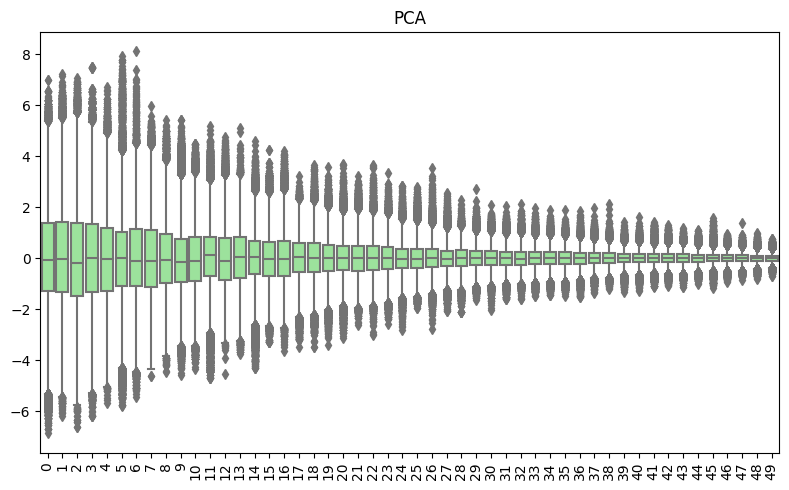

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# sns.boxplot(x, color='lightblue', ax=ax)
# ax.set_title('Raw')

sns.boxplot(x_pca, color='lightgreen', ax=ax)
ax.set_title('PCA')

ax.set_xticklabels(ax.get_xticks(), rotation=90)

plt.tight_layout()
plt.show()

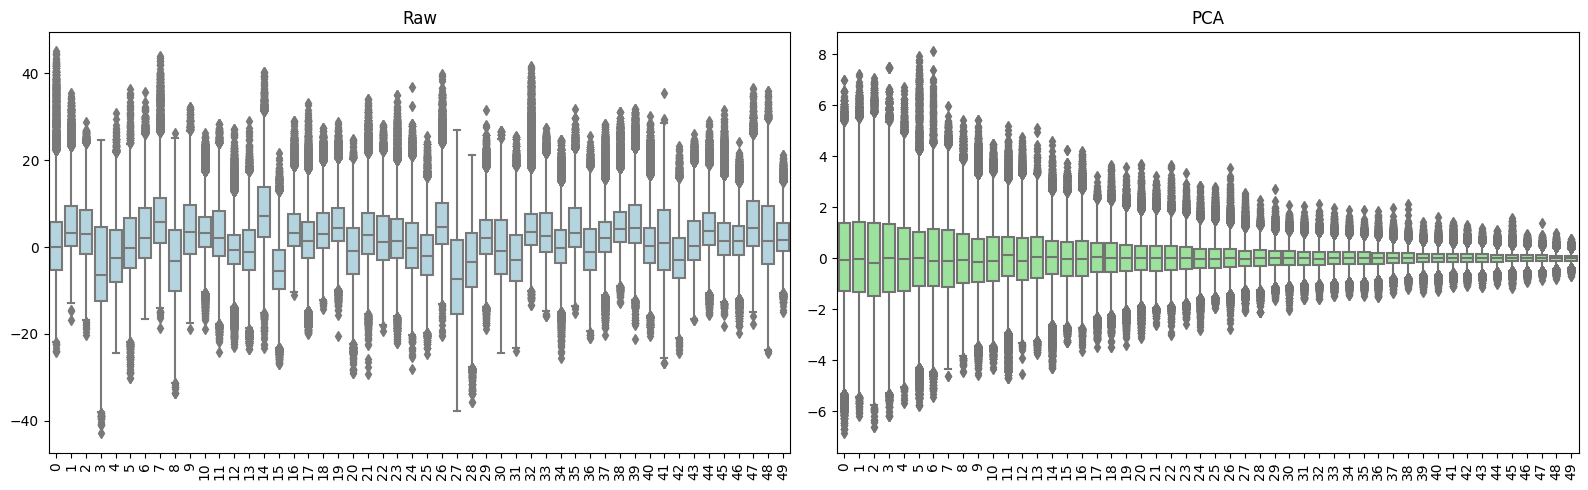

In [175]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

sns.boxplot(x, color='lightblue', ax=ax[0])
sns.boxplot(x_pca, color='lightgreen', ax=ax[1])

ax[0].set_title('Raw')
ax[1].set_title('PCA')

ax[0].set_xticklabels(ax[0].get_xticks(), rotation=90)
ax[1].set_xticklabels(ax[1].get_xticks(), rotation=90)

plt.tight_layout()
plt.show()

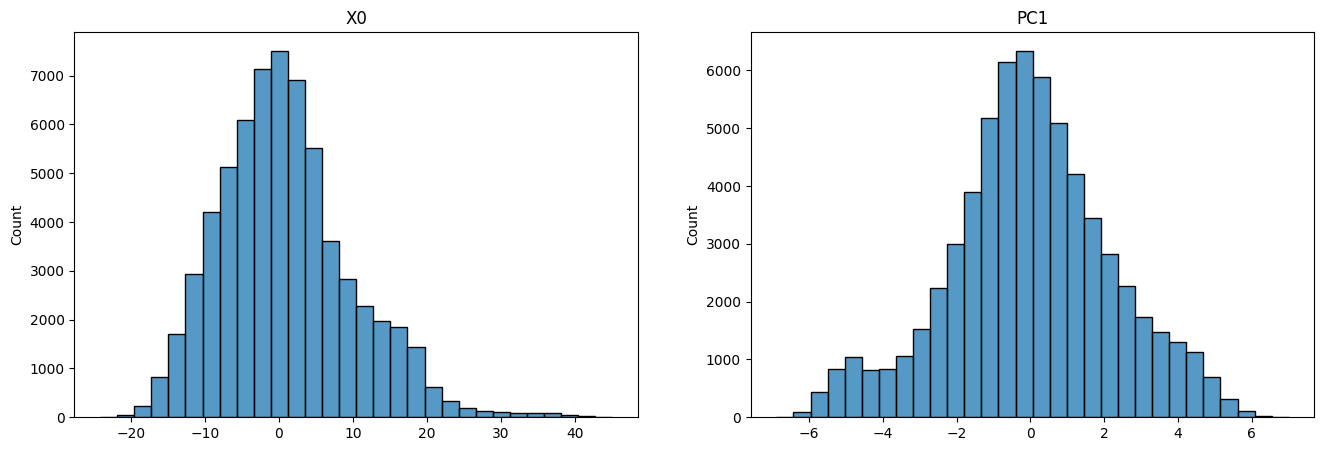

In [176]:
neuron = 0
bins=30

fig, ax = plt.subplots(1, 2, figsize=(16,5))

sns.histplot(x[:, neuron], bins=bins, ax=ax[0])
sns.histplot(x_pca[:, neuron], bins=bins, ax=ax[1])

ax[0].set_title(f'X{neuron}')
ax[1].set_title(f'PC{neuron+1}')

plt.show()

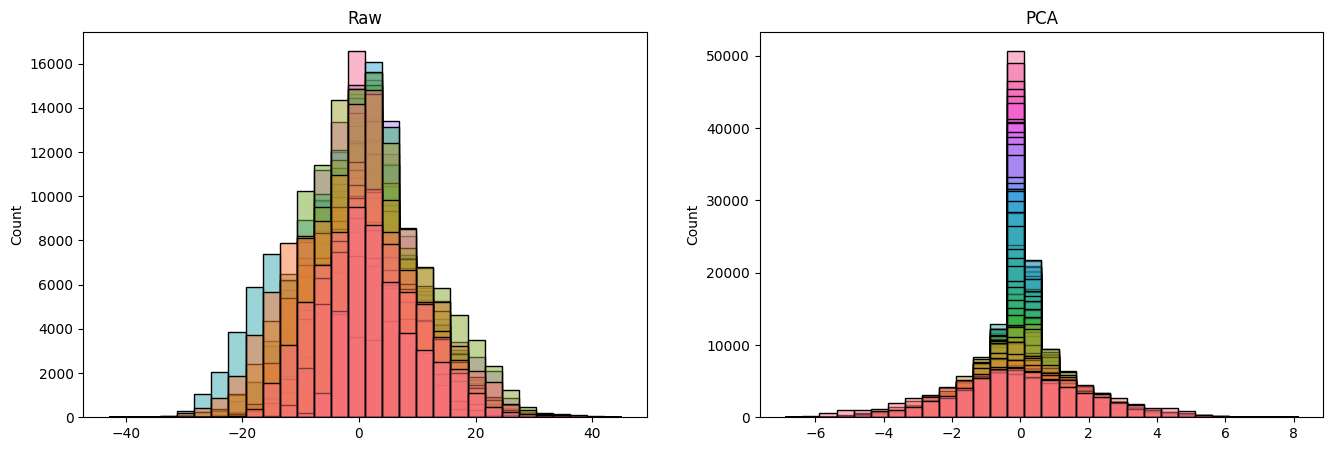

In [177]:
bins=30

fig, ax = plt.subplots(1, 2, figsize=(16,5))

sns.histplot(x, bins=bins, ax=ax[0])
sns.histplot(x_pca, bins=bins, ax=ax[1])

ax[0].set_title('Raw')
ax[1].set_title('PCA')

for a in ax.flatten(): a.get_legend().remove()

plt.show()

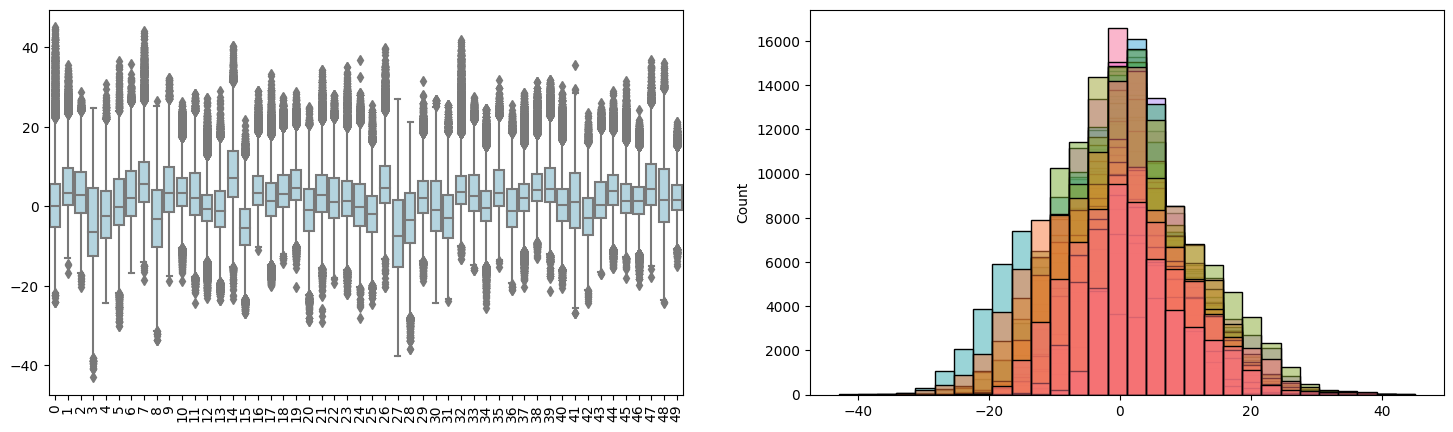

In [178]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

sns.boxplot(x, color='lightblue', ax=ax[0])
sns.histplot(x, bins=bins, ax=ax[1])

ax[0].set_title('')
ax[1].set_title('')
ax[0].set_xticklabels(ax[0].get_xticks(), rotation=90)
ax[1].get_legend().remove()

plt.show()

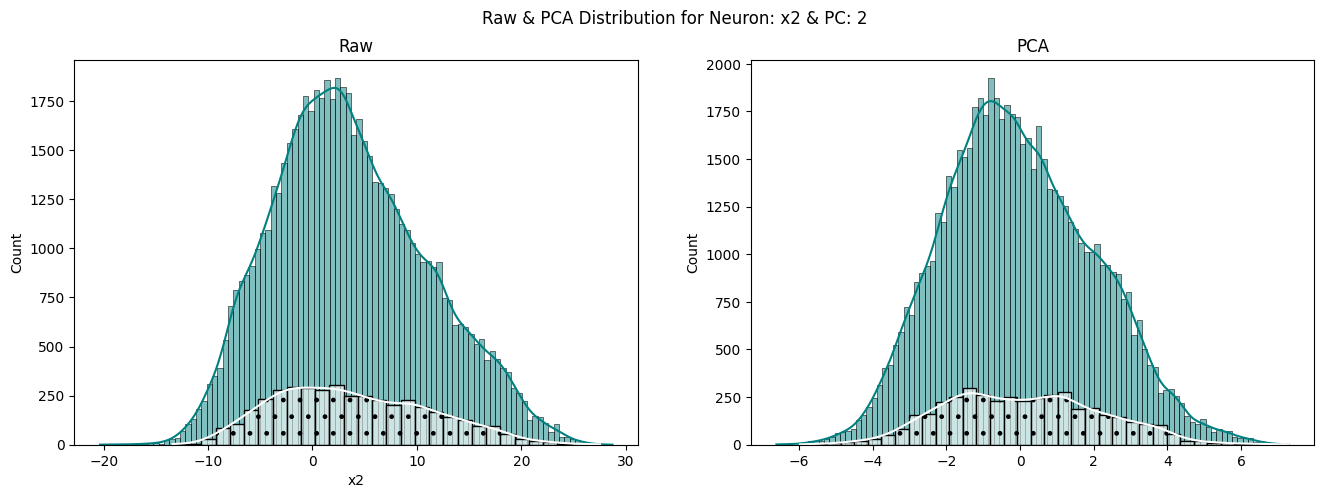

In [179]:
col = 'x2'

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(df_train[col], label=f'Train {col}', color='teal', kde=True, ax=ax[0])
sns.histplot(df_test[col], label=f'Test {col}', color='white', alpha=0.6, hatch='.', kde=True, ax=ax[0])
# sns.histplot(df_eval[col], label=f'Evaluation {col}', color='orange', alpha=0.7, kde=True, ax=ax[0])


sns.histplot(x_pca[:, int(col[1:])], label=f'Train {col}', color='teal', kde=True, ax=ax[1])
sns.histplot(x_test_pca[:, int(col[1:])], label=f'Test {col}', color='white', alpha=0.6, hatch='.', kde=True, ax=ax[1])
# sns.histplot(eval_pca[:, int(col[1:])], label=f'Evaluation {col}', color='orange', alpha=0.7, kde=True, ax=ax[1])

ax[0].set_title('Raw')
ax[1].set_title('PCA')
fig.suptitle(f'Raw & PCA Distribution for Neuron: {col} & PC: {col[1:]}')

plt.show()

## Normal Dist test

[D’Agostino and Pearson’s](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html#r7bf2e556f491-1)

In [180]:
from scipy.stats import normaltest, ks_2samp
from itertools import combinations
from sklearn.preprocessing import minmax_scale

In [181]:
sample_dist_data = {
    'Poisson': np.random.poisson(1,100),
    'Exponential': np.random.exponential(size=100),
    'Normal': np.random.randn(100),
    'Normal2': np.random.randn(100)
}

for k, v, in sample_dist_data.items():
    print(k, ':', round(normaltest(v).pvalue, 4))

Poisson : 0.0031
Exponential : 0.0
Normal : 0.3657
Normal2 : 0.7908


In [182]:
for d1, d2 in combinations(sample_dist_data.keys(), 2):
    print(f'{d1} vs {d2}: {ks_2samp(sample_dist_data[d1], sample_dist_data[d2]).pvalue:.1e}')
    
print(f'Normal vs Normal2: {ks_2samp(sample_dist_data["Normal"], sample_dist_data["Normal2"]).pvalue:.1e}')

Poisson vs Exponential: 3.2e-05
Poisson vs Normal: 3.4e-13
Poisson vs Normal2: 6.4e-10
Exponential vs Normal: 3.3e-12
Exponential vs Normal2: 6.4e-10
Normal vs Normal2: 3.7e-01
Normal vs Normal2: 3.7e-01


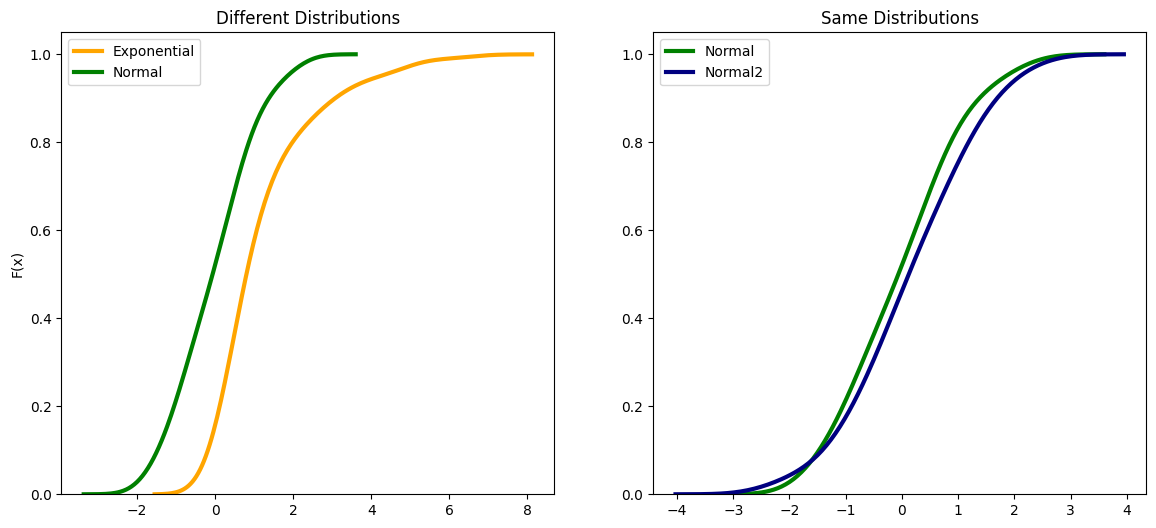

In [183]:
fig, ax = plt.subplots(1, 2, figsize=((14, 6)))

kwarg = {'linewidth': 3}

sns.kdeplot(sample_dist_data['Exponential'], cumulative=True, ax=ax[0], label='Exponential', color='orange', **kwarg)
sns.kdeplot(sample_dist_data['Normal'], cumulative=True, ax=ax[0], label='Normal', color='green', **kwarg)


sns.kdeplot(sample_dist_data['Normal'], cumulative=True, ax=ax[1], label='Normal', color='green', **kwarg)
sns.kdeplot(sample_dist_data['Normal2'], cumulative=True, ax=ax[1], label='Normal2', color='navy', **kwarg)

ax[0].set_title('Different Distributions')
ax[1].set_title('Same Distributions')

ax[0].legend()
ax[1].legend()

ax[0].set_ylabel('F(x)')
ax[1].set_ylabel('')

plt.show()

# Run Tests on Actual Data

In [184]:
p_value_thld = 5e-2

In [185]:
normality_test = pd.DataFrame({
    'neuron': df_train.drop(['y', 'true'], axis=1).columns,
    'is_normal_raw': normaltest(x).pvalue >=  p_value_thld,
    'is_normal_pca': normaltest(x_pca).pvalue >=  p_value_thld
})

normality_test.set_index('neuron', inplace=True)

In [186]:
d1 = df_train.drop(['y', 'true'], axis=1)
d2 = df_test.drop(['y', 'true'], axis=1)
d3 = df_eval.drop(['y', 'true'], axis=1)

test_stat_raw = pd.DataFrame({
    'neuron':[],
    'is_normal_train':[],
    'is_normal_test':[],
    'is_normal_eval':[],
    'same_cdf_train_test':[],
    'same_cdf_train_eval':[],
    'same_cdf_test_eval':[],
})

n = d2.shape[0]

for col in d1.columns:
    # Kolmogorov-Smirnov test
    test_stat_raw.loc[test_stat_raw.shape[0]+1] = [
        col,
        normaltest(d1[col]).pvalue,
        normaltest(d2[col]).pvalue,
        normaltest(d3[col]).pvalue,
        ks_2samp(d1[col].sample(n), d2[col], method='asymp')[1],
        ks_2samp(d1[col].sample(n), d3[col], method='asymp')[1],
        ks_2samp(d2[col], d3[col], method='asymp')[1]
    ]
    
test_stat_raw['is_normal_train'] = test_stat_raw['is_normal_train'] >= p_value_thld
test_stat_raw['is_normal_test'] = test_stat_raw['is_normal_test'] >= p_value_thld
test_stat_raw['is_normal_eval'] = test_stat_raw['is_normal_eval'] >= p_value_thld
test_stat_raw['same_cdf_train_test'] = test_stat_raw['same_cdf_train_test'] >= p_value_thld
test_stat_raw['same_cdf_train_eval'] = test_stat_raw['same_cdf_train_eval'] >= p_value_thld
test_stat_raw['same_cdf_test_eval'] = test_stat_raw['same_cdf_test_eval'] >= p_value_thld


test_stat_raw.set_index('neuron', inplace=True)

In [187]:
test_stat_raw['same_cdf_train_test'].sum() / test_stat_raw.shape[0]

0.04

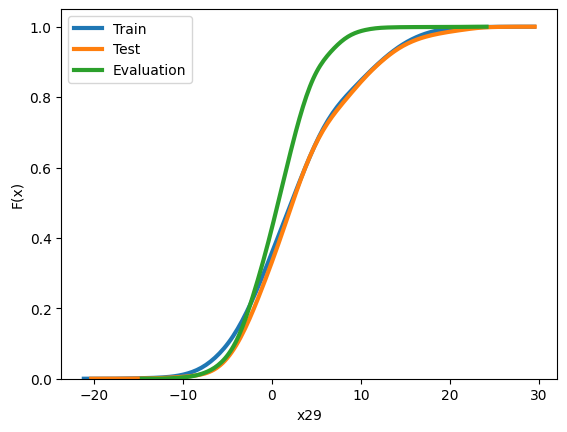

In [188]:
col = 'x29'

t = d1[col].sample(d2.shape[0]).values


sns.kdeplot(t, cumulative=True, label='Train', **kwarg)
sns.kdeplot(d2[col].values, cumulative=True, label='Test', **kwarg)
sns.kdeplot(d3[col].values, cumulative=True, label='Evaluation', **kwarg)


plt.xlabel(col)
plt.ylabel('F(x)')

plt.legend()
plt.show()

In [189]:
d1 = df_train_pca.drop(['y', 'true'], axis=1).values
d2 = df_test_pca.drop(['y', 'true'], axis=1).values
d3 = df_eval_pca.drop(['y', 'true'], axis=1).values

test_stat_pca = pd.DataFrame({
    'neuron':[],
    'is_normal_train':[],
    'is_normal_test':[],
    'is_normal_eval':[],
    'same_cdf_train_test':[],
    'same_cdf_train_eval':[],
    'same_cdf_test_eval':[],
})

for col in range(d1.shape[1]):
    # Kolmogorov-Smirnov test
    test_stat_pca.loc[test_stat_pca.shape[0]+1] = [
        f'x{int(col)}',
        normaltest(d1[:, col]).pvalue,
        normaltest(d2[:, col]).pvalue,
        normaltest(d3[:, col]).pvalue,
        ks_2samp(d1[:, col], d2[:, col], method='asymp')[1],
        ks_2samp(d1[:, col], d3[:, col], method='asymp')[1],
        ks_2samp(d2[:, col], d3[:, col], method='asymp')[1]
    ]
    
test_stat_pca['is_normal_train'] = test_stat_pca['is_normal_train'] >= p_value_thld
test_stat_pca['is_normal_test'] = test_stat_pca['is_normal_test'] >= p_value_thld
test_stat_pca['is_normal_eval'] = test_stat_pca['is_normal_eval'] >= p_value_thld
test_stat_pca['same_cdf_train_test'] = test_stat_pca['same_cdf_train_test'] >= p_value_thld
test_stat_pca['same_cdf_train_eval'] = test_stat_pca['same_cdf_train_eval'] >= p_value_thld
test_stat_pca['same_cdf_test_eval'] = test_stat_pca['same_cdf_test_eval'] >= p_value_thld


test_stat_pca.set_index('neuron', inplace=True)

In [190]:
test_stat_pca['same_cdf_train_test'].sum() / test_stat_pca.shape[0]

0.12

In [191]:
test_stat_raw.index[(test_stat_pca ^ test_stat_raw).any(axis=1)]

Index(['x0', 'x1', 'x2', 'x3', 'x5', 'x7', 'x8', 'x10', 'x13', 'x14', 'x15',
       'x17', 'x18', 'x19', 'x22', 'x23', 'x24', 'x29', 'x31', 'x32', 'x33',
       'x36', 'x38', 'x39', 'x40', 'x41', 'x43', 'x44', 'x46', 'x47', 'x49'],
      dtype='object', name='neuron')

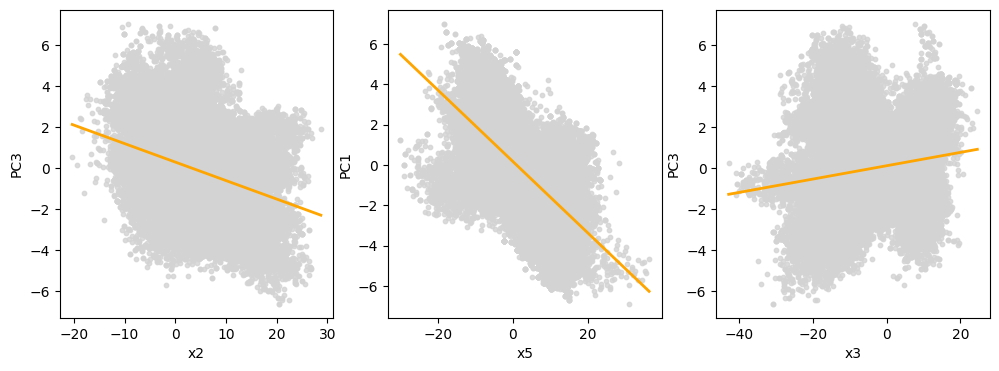

In [192]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

sns.regplot(x=df_train['x2'], y=df_train_pca['PC3'],
            scatter_kws=dict(s=10, color='lightgray'),
            line_kws=dict(color='orange', linewidth=2), ax=ax[0])
ax[0].set_xlabel('x2')
ax[0].set_ylabel('PC3')


sns.regplot(x=df_train['x5'], y=df_train_pca['PC1'],
            scatter_kws=dict(s=10, color='lightgray'),
            line_kws=dict(color='orange', linewidth=2), ax=ax[1])
ax[1].set_xlabel('x5')
ax[1].set_ylabel('PC1')


sns.regplot(x=df_train['x3'], y=df_train_pca['PC3'],
            scatter_kws=dict(s=10, color='lightgray'),
            line_kws=dict(color='orange', linewidth=2), ax=ax[2])
ax[2].set_xlabel('x3')
ax[2].set_ylabel('PC3')

plt.show()

### PCA Loadings

In [193]:
var_thld = 0.9
loadings_thld=0.2
numNeurons = x.shape[1]

In [194]:
num_component = sum(np.cumsum(pca.explained_variance_ratio_).round(2) <= var_thld)

pca_components = pd.DataFrame(
    pca.components_[:,:num_component],
    columns=[f'PC_{i}' for i in range(1, num_component+1)],
    index=[f'x{i}' for i in range(numNeurons)]
)

pca_loadings = (pca_components * np.sqrt(pca.explained_variance_[:num_component]))

In [195]:
pca_loadings.describe().T

,count,mean,std,min,25%,50%,75%,max
PC_1,50.0,0.030985,0.321464,-0.806230,-0.133630,0.053809,0.316380,0.658204
PC_2,50.0,0.030893,0.300777,-0.661764,-0.145148,0.098711,0.158586,0.827018
PC_3,50.0,-0.001929,0.295502,-0.690994,-0.223739,0.028526,0.201916,0.605481
PC_4,50.0,-0.015134,0.277950,-0.794072,-0.126189,-0.014662,0.166317,0.612243
PC_5,50.0,0.037138,0.260069,-0.529583,-0.130417,0.058290,0.252755,0.524929
PC_6,50.0,-0.001378,0.253578,-0.570443,-0.201409,0.038580,0.190212,0.503636
PC_7,50.0,0.011770,0.239177,-0.577236,-0.127089,0.027431,0.166701,0.621132
PC_8,50.0,0.039104,0.223468,-0.522378,-0.141506,0.064560,0.213661,0.407602
PC_9,50.0,0.023955,0.197652,-0.389944,-0.095347,0.005953,0.186683,0.443941
PC_10,50.0,0.007235,0.198715,-0.490222,-0.145358,-0.004527,0.106287,0.477336


In [196]:
pca_loadings

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20
x0,-0.665388,0.100597,0.214750,0.326395,0.262095,-0.492748,-0.297578,-0.150367,-0.140854,0.078179,-0.147946,0.252291,0.035223,-0.283161,0.121111,-0.021522,0.187191,0.121173,0.260102,0.044943
x1,0.036638,-0.579956,-0.305825,0.612243,-0.135622,0.020086,-0.442035,0.148128,0.093798,-0.156847,-0.103842,-0.346841,-0.028933,0.034834,-0.031280,-0.004434,-0.020066,0.002282,-0.012585,0.199637
x2,-0.017033,0.252496,-0.318610,0.143894,0.313476,0.126447,-0.078477,-0.071911,0.443941,0.376340,0.133984,0.168622,0.117577,0.006191,-0.133314,-0.083055,0.269555,-0.088081,0.056920,0.082067
x3,0.185600,-0.566214,-0.117310,-0.005641,-0.035075,0.294989,0.041341,-0.272172,-0.183340,0.245723,-0.042281,-0.052240,0.132316,0.009144,-0.211218,0.081865,0.154165,-0.066829,-0.010442,0.031460
x4,-0.444551,0.158376,0.504274,-0.247081,-0.214833,0.114509,-0.154259,0.404668,-0.166970,-0.234657,0.233884,-0.133495,0.189542,-0.073769,-0.271009,-0.235357,-0.000819,-0.020265,-0.020156,-0.010463
x5,0.236875,0.233780,0.058893,-0.126117,-0.471363,-0.231680,-0.176955,-0.151601,-0.069960,-0.002259,-0.093250,0.144617,0.278495,0.177814,0.196541,-0.062418,-0.026633,-0.021875,-0.106231,0.064548
x6,-0.128880,-0.167913,-0.470917,-0.371666,-0.091714,0.218410,0.261547,0.344926,0.215658,-0.156493,-0.380420,-0.096040,-0.116192,0.230647,-0.021878,-0.228260,0.040785,0.236074,0.000325,0.076423
x7,0.322587,0.154462,0.223202,-0.083195,0.229760,-0.087460,0.183511,-0.035023,0.004144,0.036707,-0.194981,-0.130080,-0.264652,-0.080397,-0.105032,-0.194094,-0.080502,-0.053280,0.098223,0.044516
x8,0.421928,-0.154749,0.481232,0.215831,-0.415640,0.122161,0.397375,0.243301,-0.085711,0.163091,-0.179721,0.002628,-0.248927,0.044935,0.088770,-0.087083,0.188436,0.105246,0.067927,0.063459
x9,0.082129,-0.228314,-0.022579,0.020908,-0.016192,-0.207991,0.396497,0.227550,-0.180416,0.115721,0.254568,0.155741,0.183267,-0.089635,0.195138,-0.351662,-0.081501,-0.262549,0.227313,0.014193


In [197]:
# (pca_loadings >= loadings_thld).astype(np.int8)

In [198]:
# (pca_loadings >= loadings_thld).any(axis=1).index.shape

In [199]:
var_expl_comp = (pca.explained_variance_[:num_component] / pca.explained_variance_[:num_component].sum())
# var_expl_comp

In [200]:
neuron_loadings = ((pca_loadings >= loadings_thld) * var_expl_comp).sum(axis=1)
# neuron_loadings

In [201]:
# neuron_loadings_scale.describe()

In [202]:
# # top 3rd of numNeurons
# neuron_loadings_scale.sort_values(ascending=False)[:numNeurons // 3].index.to_list()

In [204]:
# # more than the mean
# neuron_loadings_scale[neuron_loadings_scale >= neuron_loadings_scale.mean()].index.to_list()

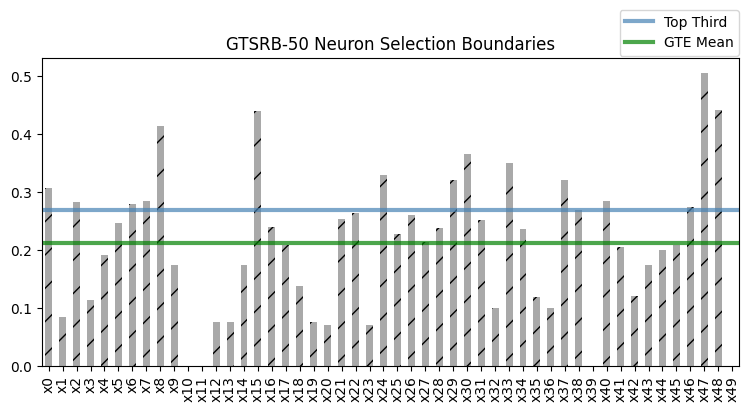

In [205]:
neuron_top_third_min = neuron_loadings.sort_values(ascending=False)[:numNeurons // 3].min()

fig, ax = plt.subplots(1, 1, figsize=(9,4))
neuron_loadings.plot.bar(color='darkgray', hatch='/', ax=ax)
ax.axhline(neuron_top_third_min, color='steelblue', linewidth=3, alpha=0.7, label='Top Third')
ax.axhline(neuron_loadings.mean(), color='green', linewidth=3, alpha=0.7, label='GTE Mean')
ax.legend(bbox_to_anchor=(0.51, 0.68, 0.5, 0.5))

ax.set_title(f'{DATASET}-{POSTFIX.split("-")[-1]} Neuron Selection Boundaries')

plt.show()

In [62]:
from utilities.scaleFunctions import applyStandardScalerSingle, fitStandardScalerSingle
from utilities.pcaFunctions import applyPCASingle, numComponents, neuronsLoadingsSingle, fitPCASingle

In [69]:
y2 = df_train['y']
true2 = df_train['true']
x2 = df_train.drop(['y', 'true'], axis=1)

In [70]:
scaler = fitStandardScalerSingle(x2, x2.shape[1])
pca = fitPCASingle(x2, scaler, x2.shape[1])

In [72]:
pca_data = applyPCASingle(x2, scaler, pca)

In [73]:
(pca.components_ == pca_scale.components_).all().all()

True

In [74]:
(pca.explained_variance_ == pca_scale.explained_variance_).all().all()

True

In [75]:
gte_mean, top_third = neuronsLoadingsSingle(pca)

In [76]:
set(gte_mean) - set(neuron_loadings_scale[neuron_loadings_scale >= neuron_loadings_scale.mean()].index.to_list())

{'x10', 'x14', 'x28', 'x31', 'x38', 'x51', 'x52', 'x56', 'x7', 'x8'}

In [77]:
set(top_third) - set(neuron_loadings_scale.sort_values(ascending=False)[:pca_scale_loadings.shape[0] // 3].index.to_list())

{'x14', 'x21', 'x25', 'x28', 'x31', 'x38', 'x7'}

In [78]:
from utilities.plotFunctions import *

(<Figure size 550x450 with 1 Axes>, <Axes: >)

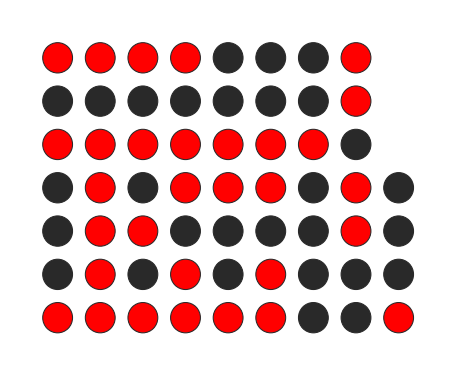

In [87]:
idx = [*map(lambda x: int(x[1:]), gte_mean)]
nn = np.zeros(x.shape[1])
nn[idx] = 1

plot_pattern(nn)